#   Q18 Machine Learning Rolling Basis

In this example we predict whether the price will rise or fall by using supervised learning (Bayesian Ridge Regression). This template represents a starting point for developing a system which can take part to the **Q18 NASDAQ-100 Stock Long-Short contest**.

It consists of two parts.

* In the **first part** we just perform a global training of the time series using all time series data. We disregard the sequential aspect of the data and use also future data to train past data.

* In the **second part** we use the built-in backtester and perform training and prediction on a rolling basis in order to avoid forward looking. Please note that we are using a **specialized** version of the Quantiacs backtester which dramatically speeds up the the backtesting process by retraining your model on a regular basis.

**Features for learning**: we will use several technical indicators trying to capture different features. You can have a look at [**Technical Indicators**](https://quantiacs.com/documentation/en/user_guide/technical_indicators.html).

Please note that:

* Your trading algorithm can open short and long positions.

* At each point in time your algorithm can trade all or a subset of the stocks which at that point of time are or were part of the NASDAQ-100 stock index. Note that the composition of this set changes in time, and Quantiacs provides you with an appropriate filter function for selecting them.

* The Sharpe ratio of your system since January 1st, 2006, has to be larger than 1.

* Your system cannot be a copy of the current examples. We run a correlation filter on the submissions and detect duplicates.

* For simplicity we will use a single asset. It pays off to use more assets, ideally uncorrelated, and diversify your positions for a more solid Sharpe ratio.

More details on the rules can be found [here](https://quantiacs.com/contest).

**Need help?** Check the [**Documentation**](https://quantiacs.com/documentation/en/) and find solutions/report problems in the [**Forum**](https://quantiacs.com/community/categories) section.

**More help with Jupyter?** Check the official [**Jupyter**](https://jupyter.org/) page.

Once you are done, click on **Submit to the contest** and take part to our competitions.

API reference:

* **data**: check how to work with [data](https://quantiacs.com/documentation/en/reference/data_load_functions.html);

* **backtesting**: read how to run the [simulation](https://quantiacs.com/documentation/en/reference/evaluation.html) and check the results.

Need to use the optimizer function to automate tedious tasks?

* **optimization**: read more on our [article](https://quantiacs.com/community/topic/29/optimizing-and-monitoring-a-trading-system-with-quantiacs).

In [1]:
# %%javascript
# IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }
# // disable widget scrolling

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import logging

import xarray as xr  # xarray for data manipulation

import qnt.data as qndata     # functions for loading data
import qnt.backtester as qnbt # built-in backtester
import qnt.ta as qnta         # technical analysis library
import qnt.stats as qnstats   # statistical functions

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

np.seterr(divide = "ignore")

from qnt.ta.macd import macd
from qnt.ta.rsi  import rsi
from qnt.ta.stochastic import stochastic_k, stochastic, slow_stochastic

from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

In [4]:
# loading S&P 500stock data

stock_data = qndata.stocks.load_spx_data(tail = 365 * 5)

100% (367973 of 367973) |################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (79197 of 79197) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (13180200 of 13180200) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/4 3s


100% (13180052 of 13180052) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 2/4 5s


100% (13179724 of 13179724) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 3/4 8s


100% (1933572 of 1933572) |##############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 4/4 9s
Data loaded 9s


In [5]:
# Explorar los campos disponibles en la dimensión "field"
print("Campos disponibles en 'field':", stock_data.coords["field"].values)

# Asegurarse de que los campos correctos existen
close_field = "close"  # Nombre del campo para precios de cierre
volume_field = "vol"  # Nombre del campo para volúmenes

if close_field not in stock_data.coords["field"].values or volume_field not in stock_data.coords["field"].values:
    raise ValueError(f"Los campos '{close_field}' y/o '{volume_field}' no están disponibles en los datos.")

# Extraer precios de cierre y volúmenes
close_prices = stock_data.sel(field=close_field)
volumes = stock_data.sel(field=volume_field)

# Eliminar activos con valores NaN en precios de cierre o volúmenes
valid_assets = ~close_prices.isnull().any(dim="time") & ~volumes.isnull().any(dim="time")
filtered_close_prices = close_prices.sel(asset=valid_assets)
filtered_volumes = volumes.sel(asset=valid_assets)

# Calcular el valor negociado diario (precio de cierre * volumen)
daily_traded_value = filtered_close_prices * filtered_volumes

# Calcular la liquidez promedio por activo (promedio a lo largo del tiempo)
average_liquidity = daily_traded_value.mean(dim="time")

# Ordenar por liquidez y seleccionar los 20 activos más líquidos
top_20_liquid_assets = average_liquidity.sortby(average_liquidity, ascending=False).head(20)

# Obtener los nombres de los activos más líquidos
top_assets = top_20_liquid_assets.asset.values

# Filtrar datos originales para estos activos más líquidos
filtered_stock_data = stock_data.sel(asset=top_assets)

# Mostrar los resultados
print("Top 20 activos más líquidos (sin valores NaN):")
print(top_assets)

Campos disponibles en 'field': ['open' 'low' 'high' 'close' 'vol' 'divs' 'split_cumprod' 'is_liquid']
Top 20 activos más líquidos (sin valores NaN):
['NAS:TSLA' 'NAS:NVDA' 'NAS:AAPL' 'NAS:AMZN' 'NAS:MSFT' 'NAS:AMD'
 'NAS:META' 'NAS:GOOGL' 'NAS:GOOG' 'NAS:NFLX' 'NYS:BA' 'NYS:JPM' 'NYS:V'
 'NYS:XOM' 'NYS:BAC' 'NAS:INTC' 'NYS:UNH' 'NYS:CRM' 'NAS:MU' 'NYS:DIS']


In [6]:
def get_features(data):
    """Build features for available assets."""

    # Verificar activos disponibles en el conjunto de datos actual
    available_assets = [asset for asset in top_assets if asset in data.coords["asset"].values]

    if not available_assets:
        raise ValueError("No matching assets found between top_assets and the current data.")

    # Filtrar datos solo para los activos disponibles
    data = data.sel(asset=available_assets)

    # Construir características
    trend = qnta.roc(qnta.lwma(data.sel(field="close"), 60), 1)
    macd = qnta.macd(data.sel(field="close"))
    macd2_line, macd2_signal, macd2_hist = qnta.macd(data, 12, 26, 9)
    volatility = qnta.tr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"))
    volatility = volatility / data.sel(field="close")
    volatility = qnta.lwma(volatility, 14)
    k, d = qnta.stochastic(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"), 14)
    rsi = qnta.rsi(data.sel(field="close"))
    price = data.sel(field="close").ffill("time").bfill("time").fillna(0)
    price = np.log(price)

    result = xr.concat(
        [trend, macd2_signal.sel(field="close"), volatility, d, rsi, price],
        pd.Index(["trend", "macd", "volatility", "stochastic_d", "rsi", "price"], name="field"),
    )

    return result.transpose("time", "field", "asset")

In [7]:
# displaying the features:
my_features = get_features(stock_data)
display(my_features.sel(field="trend").to_pandas())

asset,NAS:TSLA,NAS:NVDA,NAS:AAPL,NAS:AMZN,NAS:MSFT,NAS:AMD,NAS:META,NAS:GOOGL,NAS:GOOG,NAS:NFLX,NYS:BA,NYS:JPM,NYS:V,NYS:XOM,NYS:BAC,NAS:INTC,NYS:UNH,NYS:CRM,NAS:MU,NYS:DIS
time,,,,,,,,,,,,,,,,,,,,
2020-02-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-31,0.201056,-0.447409,-0.020030,0.278422,-0.108270,-0.375104,0.462628,0.329192,0.327447,0.340175,0.256452,0.291969,0.283611,-0.183828,0.045629,-0.368349,-0.057541,0.066491,-0.268350,0.074999
2025-02-03,0.009462,-0.525231,-0.132496,0.264191,-0.140446,-0.409331,0.493623,0.270745,0.266501,0.333603,0.236188,0.274975,0.315371,-0.172418,0.033756,-0.367683,-0.020152,0.034936,-0.308698,0.094114
2025-02-04,0.059728,-0.472119,-0.068328,0.320909,-0.129920,-0.261319,0.514683,0.349204,0.343008,0.376509,0.235888,0.278755,0.298304,-0.081557,0.063686,-0.375015,-0.035906,0.075843,-0.278056,0.064569


In [8]:
def get_target_classes(data):
    """Calculate target classes for available assets."""

    # Verificar activos disponibles en el conjunto de datos actual
    available_assets = [asset for asset in top_assets if asset in data.coords["asset"].values]

    if not available_assets:
        raise ValueError("No matching assets found between top_assets and the current data.")

    # Filtrar datos solo para los activos disponibles
    data = data.sel(asset=available_assets)

    # Calcular las clases objetivo
    close_prices = data.sel(field="close")
    target_classes = (close_prices.shift(time=-1) - close_prices) > 0  # 1 si sube, 0 si baja

    return target_classes.astype(int)

In [9]:
# displaying the target classes:
my_targetclass = get_target_classes(stock_data)
display(my_targetclass.to_pandas())

asset,NAS:TSLA,NAS:NVDA,NAS:AAPL,NAS:AMZN,NAS:MSFT,NAS:AMD,NAS:META,NAS:GOOGL,NAS:GOOG,NAS:NFLX,NYS:BA,NYS:JPM,NYS:V,NYS:XOM,NYS:BAC,NAS:INTC,NYS:UNH,NYS:CRM,NAS:MU,NYS:DIS
time,,,,,,,,,,,,,,,,,,,,
2020-02-11,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1
2020-02-12,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0
2020-02-13,0,1,1,0,1,1,1,1,1,0,0,0,1,0,0,0,0,1,0,0
2020-02-14,1,1,0,1,1,1,1,1,0,1,0,0,1,0,0,0,1,1,0,0
2020-02-18,1,1,1,1,1,1,0,1,1,0,0,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-31,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,1
2025-02-03,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,1,1,0
2025-02-04,0,1,0,0,1,0,1,0,0,1,1,1,1,0,1,1,0,1,1,0


In [10]:
def get_model():
    """This is a constructor for the ML model (Bayesian Ridge) which can be easily
       modified for using different models.
    """

    model = linear_model.BayesianRidge()
    return model

In [11]:
# Crear y entrenar modelos para los 20 activos más líquidos
models = dict()

for asset_name in top_assets:
    # drop missing values:
    target_cur   = my_targetclass.sel(asset=asset_name).dropna("time", "any")
    features_cur = my_features.sel(asset=asset_name).dropna("time", "any")

    # align features and targets:
    target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

    if len(features_cur.time) < 10:
        # not enough points for training
        continue

    model = get_model()

    try:
        model.fit(feature_for_learn_df.values, target_for_learn_df)
        models[asset_name] = model

    except:
        logging.exception("model training failed")

print(models)

{'NAS:TSLA': BayesianRidge(), 'NAS:NVDA': BayesianRidge(), 'NAS:AAPL': BayesianRidge(), 'NAS:AMZN': BayesianRidge(), 'NAS:MSFT': BayesianRidge(), 'NAS:AMD': BayesianRidge(), 'NAS:META': BayesianRidge(), 'NAS:GOOGL': BayesianRidge(), 'NAS:GOOG': BayesianRidge(), 'NAS:NFLX': BayesianRidge(), 'NYS:BA': BayesianRidge(), 'NYS:JPM': BayesianRidge(), 'NYS:V': BayesianRidge(), 'NYS:XOM': BayesianRidge(), 'NYS:BAC': BayesianRidge(), 'NAS:INTC': BayesianRidge(), 'NYS:UNH': BayesianRidge(), 'NYS:CRM': BayesianRidge(), 'NAS:MU': BayesianRidge(), 'NYS:DIS': BayesianRidge()}


Feature: 0, Score: -0.00002
Feature: 1, Score: -0.00016
Feature: 2, Score: -0.00000
Feature: 3, Score: 0.00022
Feature: 4, Score: -0.00032
Feature: 5, Score: -0.00003


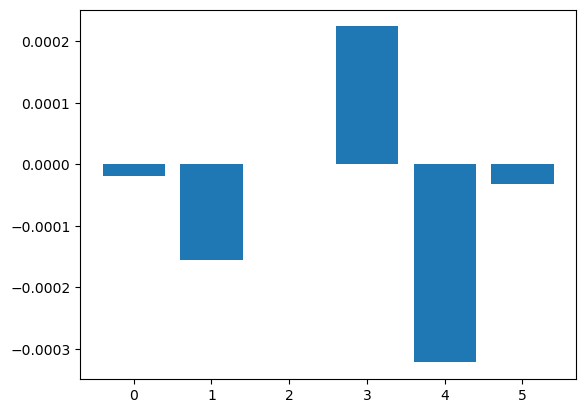

In [12]:
# Showing which features are more important in predicting:

importance = models["NAS:AAPL"].coef_
importance

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [13]:
# Performs prediction and generates output weights:

asset_name_all = stock_data.coords["asset"].values
weights = xr.zeros_like(stock_data.sel(field="close"))

for asset_name in asset_name_all:
    if asset_name in models:
        model = models[asset_name]
        features_all = my_features
        features_cur = features_all.sel(asset=asset_name).dropna("time", "any")
        if len(features_cur.time) < 1:
            continue
        try:
            weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)
        except KeyboardInterrupt as e:
            raise e
        except:
            logging.exception("model prediction failed")

print(weights)

<xarray.DataArray 'stocks_s&p500' (time: 1255, asset: 516)> Size: 5MB
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.53272198, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.53186103, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.53294209, 0.        , ..., 0.        , 0.        ,
        0.        ]])
Coordinates:
  * time     (time) datetime64[ns] 10kB 2020-02-11 2020-02-12 ... 2025-02-06
    field    <U5 20B 'close'
  * asset    (asset) <U9 19kB 'NAS:AAL' 'NAS:AAPL' ... 'NYS:ZBH' 'NYS:ZTS'


In [14]:
def get_sharpe(stock_data, weights):
    """Calculates the Sharpe ratio"""
    rr = qnstats.calc_relative_return(stock_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(stock_data, weights)
sharpe

1.0962612998463497

The sharpe ratio using the method above follows from **forward looking**. Predictions for (let us say) 2017 know about the relation between features and targets in 2020. Let us visualize the results:

In [15]:
import qnt.graph as qngraph

statistics = qnstats.calc_stat(stock_data, weights)

display(statistics.to_pandas().tail())

performance = statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())

# check for correlations with existing strategies:
qnstats.print_correlation(weights,stock_data)

field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2025-01-31,2.990346,-0.006252,0.223740,-0.015100,-0.361608,1.098599,0.245801,1.0,20.0,0.020966,205.541812
2025-02-03,2.966266,-0.008053,0.223687,-0.023031,-0.361608,1.088863,0.243565,1.0,20.0,0.020971,205.566956
2025-02-04,3.003831,0.012664,0.223659,-0.010658,-0.361608,1.102064,0.246487,1.0,20.0,0.020962,205.571574
2025-02-05,2.987678,-0.005377,0.223588,-0.015978,-0.361608,1.095423,0.244923,1.0,20.0,0.020960,205.625482
2025-02-06,2.991366,0.001234,0.223499,-0.014764,-0.361608,1.096261,0.245013,1.0,20.0,0.020963,222.594330


time,2025-02-06
field,
sharpe_ratio,1.096261


WARNING! This strategy correlates with other strategies and will be rejected.
Modify the strategy to produce the different output.


The number of systems with a larger Sharpe ratio and correlation larger than 0.9: 12
The max correlation value (with systems with a larger Sharpe ratio): 0.9340628117779107
Current sharpe ratio(3y): 0.7091885379880232



Let us now use the Quantiacs **backtester** for avoiding **forward looking**.

The backtester performs some transformations: it trains the model on one slice of data (using only data from the past) and predicts the weights for the following slice on a rolling basis:

In [16]:
def train_model(data):
    """Create and train the model working on an asset-by-asset basis."""

    # Verificar activos disponibles en el conjunto de datos actual
    available_assets = [asset for asset in top_assets if asset in data.coords["asset"].values]
    if not available_assets:
        raise ValueError("No matching assets found between top_assets and the current data.")

    features_all = get_features(data)
    target_all = get_target_classes(data)

    models = dict()

    for asset_name in available_assets:
        # drop missing values:
        target_cur = target_all.sel(asset=asset_name).dropna("time", "any")
        features_cur = features_all.sel(asset=asset_name).dropna("time", "any")

        # Alinear las características y los objetivos
        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
            continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except Exception as e:
            logging.exception(f"Model training failed for asset {asset_name}: {e}")

    return models


In [17]:
def predict_weights(models, data):
    """The model predicts if the price is going up or down.
       The prediction is performed for several days in order to speed up the evaluation."""

    # Limitar los activos a los 20 más líquidos
    asset_name_all = top_assets
    weights = xr.zeros_like(data.sel(field="close"))

    for asset_name in asset_name_all:
        if asset_name in models:
            model = models[asset_name]
            features_all = get_features(data)
            features_cur = features_all.sel(asset=asset_name).dropna("time", "any")

            if len(features_cur.time) < 1:
                continue

            try:
                weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)

            except KeyboardInterrupt as e:
                raise e

            except:
                logging.exception("model prediction failed")

    return weights

In [18]:
weights = qnbt.backtest_ml(
    train                         = train_model,
    predict                       = predict_weights,
    train_period                  =  2 * 365,
    retrain_interval              = 10 * 365,
    retrain_interval_after_submit = 1,
    predict_each_day              = False,
    competition_type              = "stocks_nasdaq100",
    lookback_period               = 365,
    start_date                    = "2005-01-01",
    analyze                       = True,
    build_plots                   = True
)


Run the last iteration...


100% (44115 of 44115) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (8948288 of 8948288) |##############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/1 2s
Data loaded 2s


100% (685324 of 685324) |################| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/1 2s
Data loaded 2s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.
Write output: /root/fractions.nc.gz
State saved.
---
Run First Iteration...


100% (44115 of 44115) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (9037908 of 9037908) |##############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/1 2s
Data loaded 2s
---
Run all iterations...
Load data...


100% (44115 of 44115) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (13049888 of 13049888) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/8 1s


100% (13049888 of 13049888) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 2/8 1s


100% (13049888 of 13049888) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 3/8 2s


100% (13049864 of 13049864) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 4/8 3s


100% (13049796 of 13049796) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 5/8 4s


100% (13049796 of 13049796) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 6/8 5s


100% (13049796 of 13049796) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 7/8 5s


100% (13049864 of 13049864) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 8/8 6s
Data loaded 6s


100% (44115 of 44115) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (12967240 of 12967240) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/7 1s


100% (12967236 of 12967236) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 2/7 2s


100% (12967236 of 12967236) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 3/7 2s


100% (12967212 of 12967212) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 4/7 3s


100% (12967132 of 12967132) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 5/7 4s


100% (12967132 of 12967132) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 6/7 5s


100% (12967212 of 12967212) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 7/7 6s
Data loaded 6s
Backtest...


100% (44115 of 44115) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (13069800 of 13069800) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/7 1s


100% (13069796 of 13069796) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 2/7 2s


100% (13069796 of 13069796) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 3/7 3s


100% (13069772 of 13069772) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 4/7 3s


100% (13069692 of 13069692) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 5/7 4s


100% (13069692 of 13069692) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 6/7 5s


100% (13069772 of 13069772) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 7/7 6s
Data loaded 6s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.
Write output: /root/fractions.nc.gz
State saved.
---
Analyze results...
Check...
Check liquidity...
Ok.
Check missed dates...
Ok.
Check the sharpe ratio...
Period: 2006-01-01 - 2025-02-06
Sharpe Ratio = 0.8890417316321265
Ok.
---
Align...
Calc global stats...
---
Calc stats per asset...
Build plots...
---
Select the asset (or leave blank to display the overall stats):


interactive(children=(Combobox(value='', description='asset', options=('', 'NAS:AAL', 'NAS:AAPL', 'NAS:ABNB', …

100% (5057 of 5057) |####################| Elapsed Time: 0:00:17 Time:  0:00:17


The Sharpe ratio is obviously smaller as the training process is not looking forward (as it happens by processing data on a global basis), but performed on a rolling basis.

# May I import libraries?

Yes, please refer to the file **init.ipynb** in your home directory. You can for example use:

! conda install -y scikit-learn

# How to load data?

Daily stock data for the **Q18 Nasdaq-100** contest can be loaded using:
```python
data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Cryptocurrency daily data used for the Q16/Q17 contests can be loaded using:
```python
data = qndata.cryptodaily.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Futures data for the Q15 contest can be loaded using:
```python
data= qndata.futures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

BTC Futures data for the Q15 contest can be loaded using:
```python
data= qndata.cryptofutures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

# How to view a list of all tickers?

```python
data.asset.to_pandas().to_list()
```

# How to see which fields are available?

```python
data.field.to_pandas().to_list()
```

# How to load specific tickers?

```python
data = qndata.stocks.load_ndx_data(tail=17 * 365, assets=["NAS:AAPL", "NAS:AMZN"])
```

# How to select specific tickers after loading all data?

```python
def get_data_filter(data, assets):
    filler= data.sel(asset=assets)
    return filler

get_data_filter(data, ["NAS:AAPL", "NAS:AMZN"])
```

# How to get the prices for the previous day?

```python
qnta.shift(data.sel(field="open"), periods=1)
```

or:

```python
data.sel(field="open").shift(time=1)
```

# How to get the Sharpe ratio?

```python
import qnt.stats as qnstats

def get_sharpe(market_data, weights):
    rr = qnstats.calc_relative_return(market_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(data, weights) # weights.sel(time=slice("2006-01-01",None))
```

# How do I get a list of the top 3 assets ranked by Sharpe ratio?

```python
import qnt.stats as qnstats

data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))

def get_best_instruments(data, weights, top_size):
    # compute statistics:
    stats_per_asset = qnstats.calc_stat(data, weights, per_asset=True)
    # calculate ranks of assets by "sharpe_ratio":
    ranks = (-stats_per_asset.sel(field="sharpe_ratio")).rank("asset")
    # select top assets by rank "top_period" days ago:
    top_period = 1
    rank = ranks.isel(time=-top_period)
    top = rank.where(rank <= top_size).dropna("asset").asset

    # select top stats:
    top_stats = stats_per_asset.sel(asset=top.values)

    # print results:
    print("SR tail of the top assets:")
    display(top_stats.sel(field="sharpe_ratio").to_pandas().tail())

    print("avg SR = ", top_stats[-top_period:].sel(field="sharpe_ratio").mean("asset")[-1].item())
    display(top_stats)
    return top_stats.coords["asset"].values

get_best_instruments(data, weights, 3)
```

# How can I check the results for only the top 3 assets ranked by Sharpe ratio?

Select the top assets and then load their data:

```python
best_assets= get_best_instruments(data, weights, 3)

data= qndata.stocks.load_ndx_data(tail = 17*365, assets=best_assets)
```

# How can prices be processed?

Simply import standard libraries, for example **numpy**:

```python
import numpy as np

high= np.log(data.sel(field="high"))
```

# How can you reduce slippage impace when trading?

Just apply some technique to reduce turnover:

```python
def get_lower_slippage(weights, rolling_time=6):
    return weights.rolling({"time": rolling_time}).max()

improved_weights = get_lower_slippage(weights, rolling_time=6)
```

# How to use technical analysis indicators?

For available indicators see the source code of the library: /qnt/ta

## ATR

```python
def get_atr(data, days=14):
    high = data.sel(field="high") * 1.0
    low  = data.sel(field="low") * 1.0
    close= data.sel(field="close") * 1.0

    return qnta.atr(high, low, close, days)

atr= get_atr(data, days=14)
```

## EMA

```python
prices= data.sel(field="high")
prices_ema= qnta.ema(prices, 15)
```

## TRIX

```python
prices= data.sel(field="high")
prices_trix= qnta.trix(prices, 15)
```

## ADL and EMA

```python
adl= qnta.ad_line(data.sel(field="close")) * 1.0
adl_ema= qnta.ema(adl, 18)
```

# How can you check the quality of your strategy?

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

or

```python
stat= qnstats.calc_stat(data, weights)
display(stat.to_pandas().tail())
```

or

```python
import qnt.graph   as qngraph
statistics= qnstats.calc_stat(data, weights)
display(statistics.to_pandas().tail())

performance= statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())
qnstats.print_correlation(weights, data)

```

# An example using pandas

One can work with pandas DataFrames at intermediate steps and at the end convert them to xarray data structures:

```python
def get_price_pct_change(prices):
    prices_pandas = prices.to_pandas()
    assets = data.coords["asset"].values
    for asset in assets:
        prices_pandas[asset] = prices_pandas[asset].pct_change()
    return prices_pandas

prices = data.sel(field="close") * 1.0
prices_pct_change = get_price_pct_change(prices).unstack().to_xarray()
```

# How to submit a strategy to the competition?

Check that weights are fine:

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

If everything is ok, write the weights to file:

```python
qnout.write(weights)
```

In your **personal account**:

* **choose** a strategy;
* click on the **Submit** button;
* select the type of competition.

At the beginning you will find the strategy under the **Checking** area:

* **Sent strategies** > **Checking**.

If technical checks are successful, the strategy will go under the **Candidates** area:

* **Sent strategies** > **Candidates**.

Otherwise it will be **Filtered**:

* **Sent strategies** > **Filtered**

and you should inspect error and warning messages.

Note that a strategy under the **Candidates** area should have a Sharpe ratio larger than 1 for being eligible for a prize. Please check warning messages in your **Candidates** area!